### Подключение библиотек и скриптов

In [321]:
import numpy as np
import pandas as pd
import pickle

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [322]:
import warnings
warnings.filterwarnings('ignore')

In [323]:
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [324]:
PREPARED_TRAIN_PATH = 'train_prepared.csv'
PREPARED_TRAIN_LSNAN_PATH = 'train_prepared_lsnan.csv'
TRAIN_DATASET_PATH = '../train.csv'
TEST_DATASET_PATH = '../test.csv'
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_TRAIN_PATH = 'model.pkl' 
MODEL_SVN_LIFESQUARE_PATH = 'model_svm_ls.pkl' 
MODEL_TRAIN_KMEANS= 'model_kmeans.pkl'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности
* **Social_1**, **Social_2**, **Social_3** - социальные показатели местности
* **Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [325]:
# заменяет Площади плохих кухонь (анпример больше 1000) на средние в зависимости от размера обющей площади
def Correct_BadSquare(df, IndexBadSquare, ColumnBadSquare='KitchenSquare', percentiles=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,1], ):
   
    # разбиваем датасет по колонке Square на процентили Чтобы вычислить медиану для каждого поромежутка
    qcut=pd.qcut(df.Square, percentiles)
    df_qcut=pd.DataFrame({'Interval': qcut} )
    # Вычисляем среднюю площадь кухонь  по интервалам квантелям Общей площади
    meanSquareByPeriods=df.groupby(qcut).mean()[ColumnBadSquare].rename('meanKS')
    # Создаем датафрейм где в колонке Interval вставлены интервалы (квантили) площади Square, полученный с помощью qcut
    # а в колонке meanKS - средня площадь по кухням  
    df_meanKS=df_qcut.merge(meanSquareByPeriods,how='left',left_on='Interval', right_on='Square', sort=False, copy=True).set_index(df.index)
    df_meanKS
    # IndexBadKitchens= df[df['KitchenSquare']>1000].index
    df.loc[IndexBadSquare, ColumnBadSquare]= df_meanKS.loc[IndexBadSquare, 'meanKS']

In [326]:
def reduce_dims_to_2D_space_with_PCA(df):
    pca = PCA(n_components=2)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    
def reduce_dims_to_3D_space_with_PCA(df):
    pca = PCA(n_components=3)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

def reduce_dims_to_2D_space_with_TSNE(df):
    tsne = TSNE(n_components=2, learning_rate=250, random_state=42)
    components = tsne.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    
def reduce_dims_to_3D_space_with_TSNE(df):
    tsne = TSNE(n_components=3, learning_rate=250, random_state=42)
    components = tsne.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])  

In [327]:
def display_clusters_distribution(unique_labels, labels_counts):
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clгsters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

def apply_elbow_method(X):
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
    
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=labels.name, cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=(15,10))
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=(15,10))

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=labels, cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [328]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [329]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [330]:
 df.info()
# мы видим что пропуск данных есть только в колонках: LifeSquare(7887) и Healthcare_1 (5202)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [331]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [332]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [333]:
# устанавливаем колонку id  как индекс у данных train
df.set_index("Id", inplace=True)

In [334]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


### Анализ целевой переменной

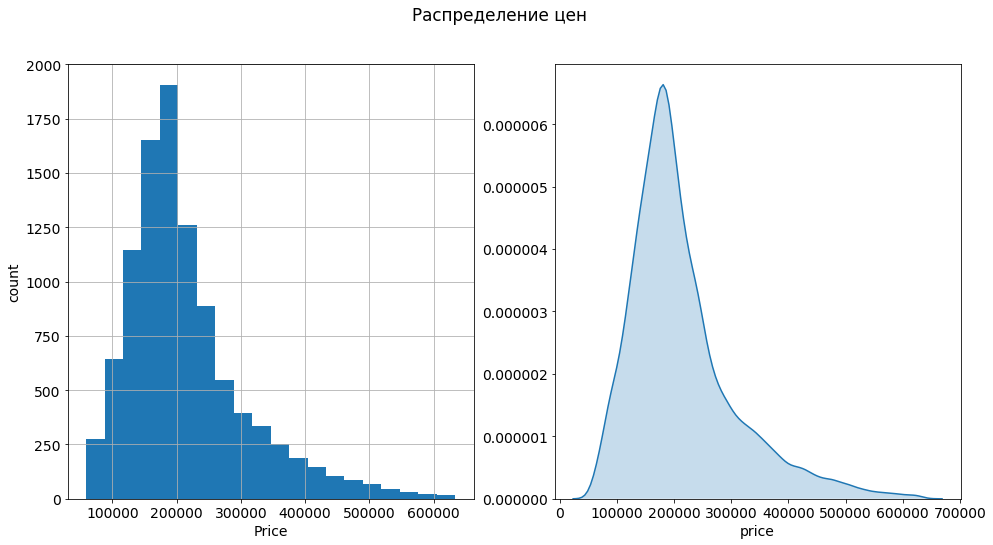

In [335]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Распределение цен')
plt.show()

In [336]:
# Вывод Среднего , медианы и моды Price
price_mean = round(df['Price'].mean(), 2)
price_median = df['Price'].median()
price_mode = df['Price'].mode()[0]
print(pd.DataFrame({'price_mean':[price_mean], 'price_median': [price_median], 'price_mode' :[price_mode]}))

   price_mean   price_median    price_mode
0   214138.86  192269.644879  59174.778028


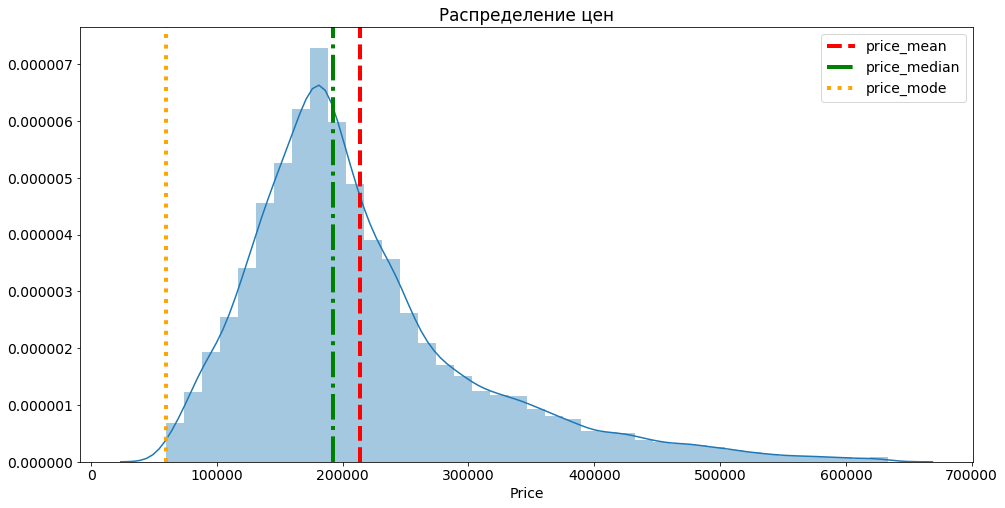

In [337]:
# Мода Price нам не интересна так как цены все разные  
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=40)

plt.axvline(price_mean, 0, 1, label='price_mean', c='red', linestyle="--",linewidth=4)
plt.axvline(price_median, 0, 1, label='price_median', c='green', linestyle="-.",linewidth=4)
plt.axvline(price_mode, 0, 1, label='price_mode', c='orange', linestyle=":",linewidth=4)


plt.title('Распределение цен')
plt.legend()
plt.show()

In [338]:
df['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

**Количественные признаки**

In [339]:
df_num_features = df.select_dtypes(include=['float64','int64'])
df_num_features.corr()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
DistrictId,1.000000,0.071432,-0.026613,-0.019910,0.040358,-0.120373,-0.149051,0.013430,0.065294,0.246463,0.167479,0.136095,0.304335,0.306147,0.174214,0.265100
Rooms,0.071432,1.000000,0.662893,0.131336,0.005123,-0.000665,-0.029302,-0.010612,-0.032347,0.075980,0.071335,0.012811,0.042857,0.063557,0.053618,0.550291
Square,-0.026613,0.662893,1.000000,0.196129,0.008320,0.114791,0.081505,-0.009032,-0.064479,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,0.520075
LifeSquare,-0.019910,0.131336,0.196129,1.000000,-0.001195,0.024559,0.027442,-0.002210,-0.023629,-0.048363,-0.039283,0.012763,-0.026867,-0.024762,-0.007569,0.081292
KitchenSquare,0.040358,0.005123,0.008320,-0.001195,1.000000,-0.011397,0.000780,0.000958,-0.005622,0.043379,0.037805,-0.015140,0.009472,0.043170,0.010216,0.028864
Floor,-0.120373,-0.000665,0.114791,0.024559,-0.011397,1.000000,0.418986,0.000928,-0.016133,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,0.128715
HouseFloor,-0.149051,-0.029302,0.081505,0.027442,0.000780,0.418986,1.000000,-0.000864,-0.004362,-0.020801,0.007194,-0.008137,-0.143973,-0.068728,0.026279,0.088280
HouseYear,0.013430,-0.010612,-0.009032,-0.002210,0.000958,0.000928,-0.000864,1.000000,0.001465,0.003026,0.001970,0.000819,-0.011969,0.011245,0.003681,0.004305
Ecology_1,0.065294,-0.032347,-0.064479,-0.023629,-0.005622,-0.016133,-0.004362,0.001465,1.000000,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,-0.058381
Social_1,0.246463,0.075980,-0.070690,-0.048363,0.043379,-0.044914,-0.020801,0.003026,0.026464,1.000000,0.955988,0.023721,0.077133,0.524593,0.526272,0.263286


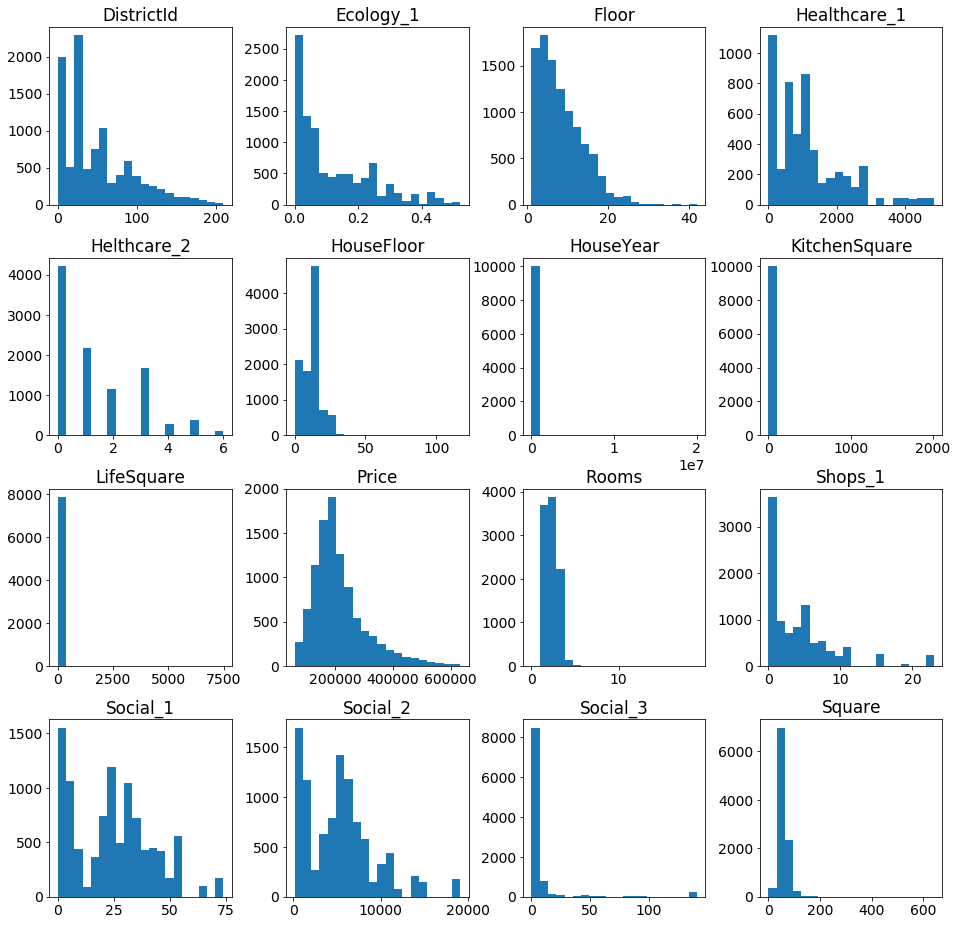

In [340]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [341]:
df.LifeSquare.describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

(array([7.886e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.70619419e-01, 7.48392770e+02, 1.49641492e+03, 2.24443707e+03,
        2.99245922e+03, 3.74048137e+03, 4.48850353e+03, 5.23652568e+03,
        5.98454783e+03, 6.73256998e+03, 7.48059213e+03]),
 <a list of 10 Patch objects>)

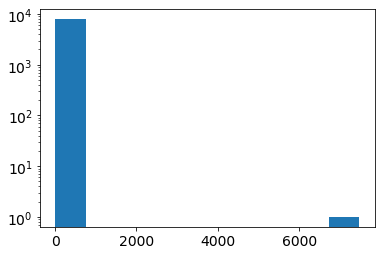

In [342]:
# вывод гистоuраммы LifeSquare .котрая показывает выброс значения
plt.hist(df['LifeSquare'], log=True)

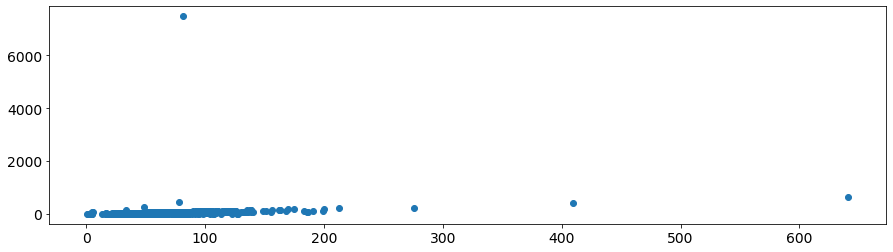

In [343]:
# посмотрим насколько коррелируют  колонки Square и LifeSquare

#df_notNan_ls
plt.rcParams['figure.figsize'] = 15, 4
plt.scatter(df['Square'],df['LifeSquare'])

In [344]:
df1=df.copy()

In [345]:
# на графике мы видим выброс ОШИБОЧНЫЙ ( скорей всего опечатка) по колонке LifeSquare 
# , т.к. общая площать  81.694417 а жилая 7480.592129

df[df['LifeSquare']>6000].index

Int64Index([16550], dtype='int64', name='Id')

In [346]:
# заменим его на 74.80 Ю так кона именно корректная
df.loc[16550, 'LifeSquare']=74.80
df.loc[16550, :]

DistrictId              27
Rooms                    3
Square             81.6944
LifeSquare            74.8
KitchenSquare            1
Floor                    9
HouseFloor              17
HouseYear             2016
Ecology_1        0.0176471
Ecology_2                B
Ecology_3                B
Social_1                 2
Social_2               469
Social_3                 0
Healthcare_1           NaN
Helthcare_2              0
Shops_1                  0
Shops_2                  B
Price               217357
Name: 16550, dtype: object

In [347]:
# и удалим некорректное значение (выброс > 6000) по колонке LifeSquare а также оставим NAN, чтобы из позже обучить
# df_corrected=df[np.logical_or(df['LifeSquare']<6000, np.isnan(df['LifeSquare']))]
# df_corrected.shape


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275


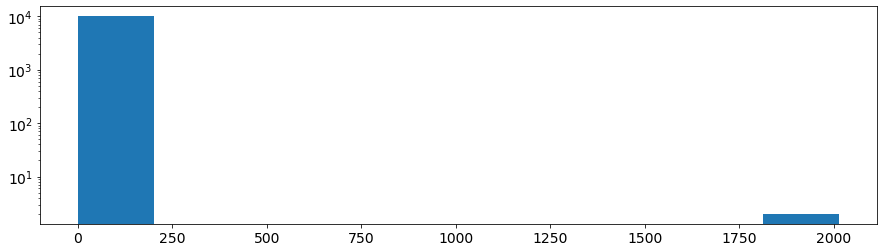

In [348]:
# по гистонрамма выше мы видим также выброс по колонке  KitchenSquare
# вывод гистоuраммы LifeSquare .котрая показывает выброс значения
plt.hist(df['KitchenSquare'], log=True)

df[df['KitchenSquare']>250]


In [349]:
# в наборе присутствуют данные в которых кухня больне общей площади. 
df[df['KitchenSquare']>df['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165
6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960518
14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275


In [350]:
df1=df.copy()

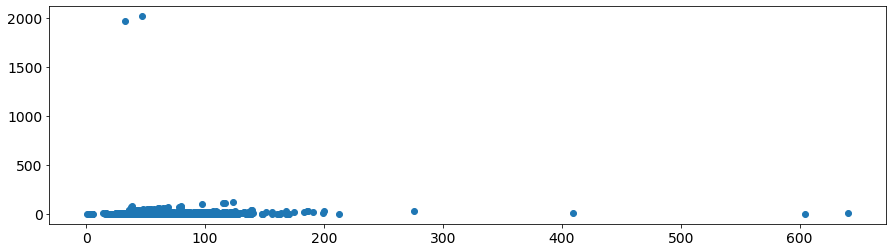

In [351]:
# посмотрим насколько коррелируют  колонки Square и KitchenSquare
#df_notNan_ls
plt.rcParams['figure.figsize'] = 15, 4
plt.scatter(df['Square'],df['KitchenSquare'])

In [352]:
# заменяем Плохие кухни на средние 
Correct_BadSquare(df, df[df['KitchenSquare']>1000].index, ColumnBadSquare='KitchenSquare')

In [353]:
# Выводим только те ячесйки которые поменялись ( проверяем что поменяли именно нужные)
df.loc[df1['KitchenSquare'] != df['KitchenSquare'],:]
# все верно поменялись только верные ячейки


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,7.185,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
14679,81,1.0,32.276663,19.278394,7.368,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275


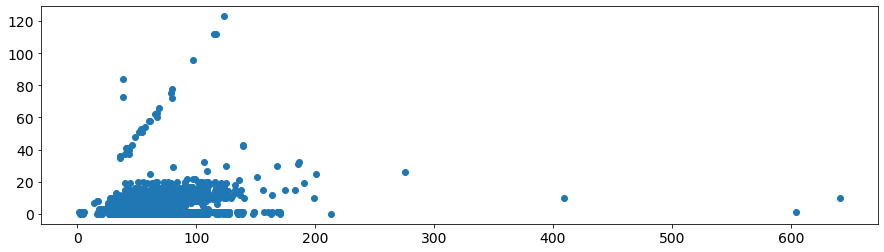

In [354]:
# посмотрим исправились ли Кухни и проверим опять корреляцию. Кк видим Выброс кухонь изменились
#df_notNan_ls
plt.rcParams['figure.figsize'] = 15, 4
plt.scatter(df['Square'],df['KitchenSquare'])

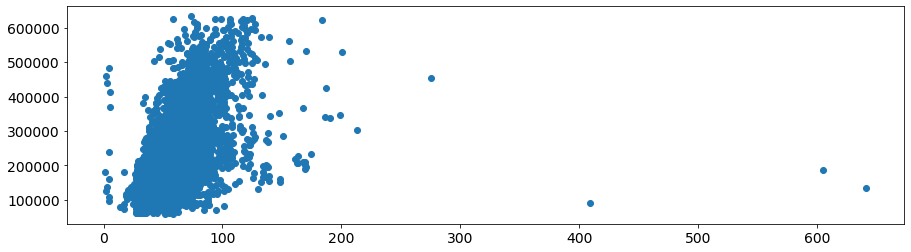

In [355]:
# посмотрим насколько коррелируют  колонки Square и цена
#df_notNan_ls
plt.rcParams['figure.figsize'] = 15, 4
plt.scatter(df['Square'],df['Price'])

In [356]:
df1=df.copy()

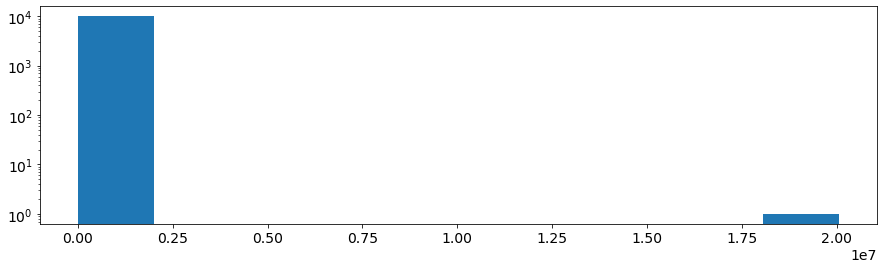

In [357]:
plt.hist(df['HouseYear'], log=True)
# убираем даты заведома неправильные > 2020

df.loc[df['HouseYear']>2020, 'HouseYear']=int(df.loc[df['HouseYear']<2020, 'HouseYear'].median())


(array([  16.,   13.,   45.,   34.,  851., 1817., 3719.,  755.,  913.,
        1837.]),
 array([1910., 1921., 1932., 1943., 1954., 1965., 1976., 1987., 1998.,
        2009., 2020.]),
 <a list of 10 Patch objects>)

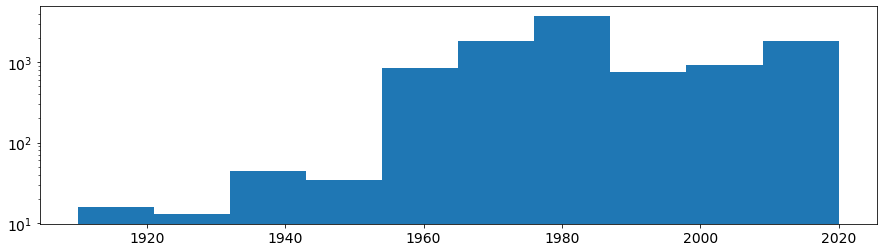

In [358]:
# проверяем что заменили некорректные данные HouseYear на медиану
plt.hist(df['HouseYear'], log=True)

## заполнение пропущенных ячеек  колонки LifeSquare
 

In [359]:
df2=df.copy()

In [360]:
# в колонке LifeSquare незаполнены более 800 колонок. попытаемся их заполнить

In [361]:
# columns_ls это колонки , которые будут учавствовать в обучении LifeSquare
columns_ls =['DistrictId', 'Rooms','Square','KitchenSquare','HouseFloor', 'HouseYear']

In [362]:
# df_ls это датасет  train с ненулевыми значениями в колонке LifeSquare (а также там удален некорректный 1 выброс)
df_notNan_ls=df[df['LifeSquare'].notnull()]
df_notNan_ls.shape

(7887, 19)

In [363]:
X=df_notNan_ls[columns_ls]
X

,DistrictId,Rooms,Square,KitchenSquare,HouseFloor,HouseYear
Id,,,,,,
14038,35,2.0,47.981561,6.0,9.0,1969
15053,41,3.0,65.683640,8.0,9.0,1978
4765,53,2.0,44.947953,0.0,12.0,1968
5809,58,2.0,53.352981,9.0,17.0,1977
10783,99,1.0,39.649192,7.0,12.0,1976
...,...,...,...,...,...,...
48,13,3.0,80.631333,10.0,14.0,1999
77,32,2.0,50.401785,5.0,5.0,1968
6159,18,1.0,41.521546,9.0,13.0,2000


In [364]:
y=df_notNan_ls['LifeSquare']
y

Id
14038    29.442751
15053    40.049543
4765     29.197612
5809     52.731512
10783    23.776169
           ...    
48       48.899083
77       30.476203
6159     20.539216
5400     33.840147
6306     21.157874
Name: LifeSquare, Length: 7887, dtype: float64

In [365]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,36.260658,5.876355,8.526700,12.609400,1984.863800,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,20.278483,5.174052,5.241148,6.775974,18.409979,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,638.163193,123.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

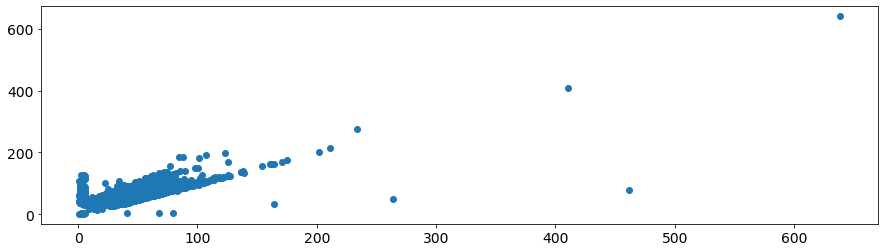

In [367]:
plt.scatter(df1['LifeSquare'], df1['Square'])

In [368]:
# на всякий случай сораянем датасет
df2=df.copy()

In [369]:
#убеждаемся что пустых 2113
df2[df2['LifeSquare'].isnull()].index

Int64Index([11993,  5172, 11935,  6641,  5073,  7550, 11703,  9371,   175,
             1821,
            ...
             6612,  6097,  5071,  3621, 13725, 16159,  2996, 15623,  4158,
             5123],
           dtype='int64', name='Id', length=2113)

In [370]:

# заменяем Плохие кухни на средние 
Correct_BadSquare(df, df[df['LifeSquare'].isnull()].index, ColumnBadSquare='LifeSquare')

In [371]:
# Выводим только те ячесйки которые поменялись ( проверяем что поменяли именно нужные)
df.loc[df2['LifeSquare'] != df['LifeSquare'],:]
# все верно поменялись только верные ячейки
# именно столько ми поменялись отлично

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11993,74,2.0,80.312926,50.967624,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
5172,1,2.0,64.511437,44.974909,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
11935,27,2.0,64.711835,44.974909,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
6641,54,3.0,118.907612,115.072765,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
5073,74,2.0,82.667915,61.570282,1.0,16,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,244145.827069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16159,27,1.0,38.968338,23.571702,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.569405
2996,1,2.0,64.994245,44.974909,1.0,9,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.511658
15623,23,2.0,55.620092,35.412643,0.0,2,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.553006


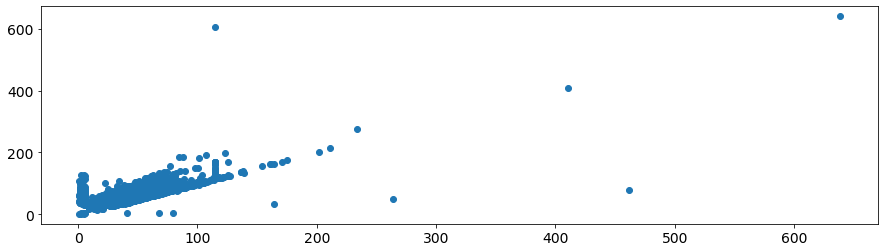

In [372]:
# посмотрим поменяли ли зависимости lifeSquare  от Square
plt.scatter(df['LifeSquare'], df['Square'])
# видим график остался пержним - значит мы не ухудшили ситуацию. ОТлично

In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [374]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.091272,5.876355,8.526700,12.609400,1984.863800,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,19.443437,5.174052,5.241148,6.775974,18.409979,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,23.735710,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,33.383038,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.050483,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,638.163193,123.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### создаем  из классовых еперменных в битовые

In [375]:
# удаляем  колонку Healthcare_1, так как в ней очень мало данных, а также прайс
df_features =df.drop(['Price','Healthcare_1'], axis=1).copy()
df_features =pd.get_dummies(X1)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Social_1       10000 non-null  int64  
 10  Social_2       10000 non-null  int64  
 11  Social_3       10000 non-null  int64  
 12  Helthcare_2    10000 non-null  int64  
 13  Shops_1        10000 non-null  int64  
 14  Ecology_2_A    10000 non-null  uint8  
 15  Ecology_2_B    10000 non-null  uint8  
 16  Ecology_3_A    10000 non-null  uint8  
 17  Ecology_3_B    10000 non-null  uint8  
 18  Sho

In [376]:
## сохраняем препарированную базу С изменнеыми LifeSquare , KitchenSquare, и Yearhouse
df_features.to_csv(PREPARED_TRAIN_PATH, index=True, encoding='utf-8')

### пытаемся кластеризовать переменную DistrictId

In [377]:
components_2d = reduce_dims_to_2D_space_with_PCA(df_features)

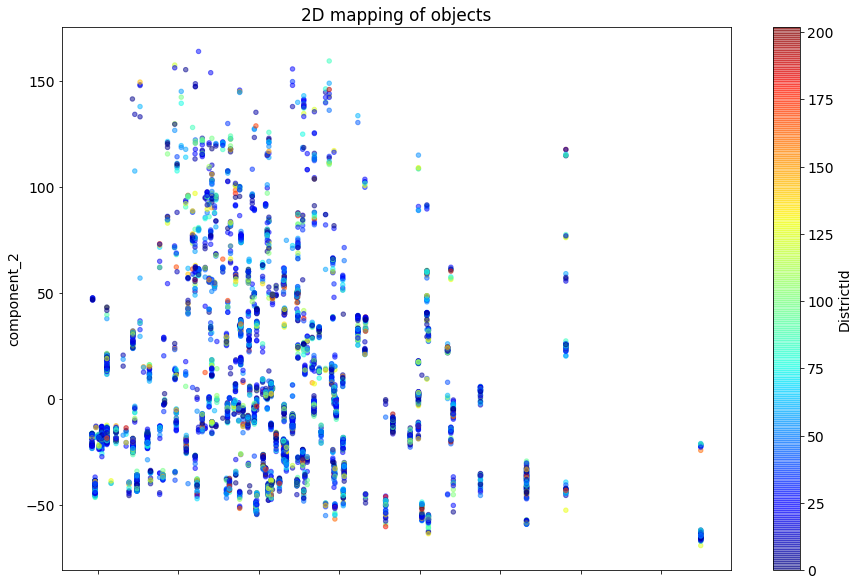

In [378]:
display_components_in_2D_space(components_2d, df['DistrictId'])

**Снижение размерности до 3х компонент**

In [379]:
components_3d = reduce_dims_to_3D_space_with_PCA(df_features)
components_3d

,component_1,component_2,component_3
0,2623.828336,-18.145282,-14.088061
1,4956.861753,-18.465538,7.441286
2,2406.859109,-0.485465,-17.098184
3,382.836670,6.577543,6.280623
4,423.976776,48.547264,-21.491541
...,...,...,...
9995,2607.876902,-20.356490,-12.310948
9996,209.813812,-33.856111,-21.093143
9997,-4723.244891,-18.308180,-7.031202
9998,-304.082166,28.558690,-15.053570


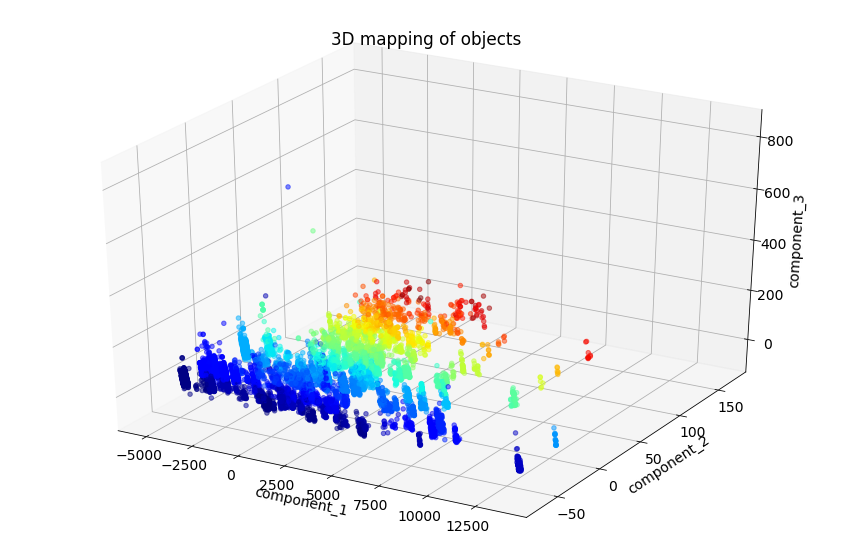

In [380]:
display_components_in_3D_space(components_3d, df['DistrictId'])

In [381]:
# Видим что на Колонке кластеризуются

## Кластеризация: k-means

### Оценка оптимального количества кластеров методом "Локтя"

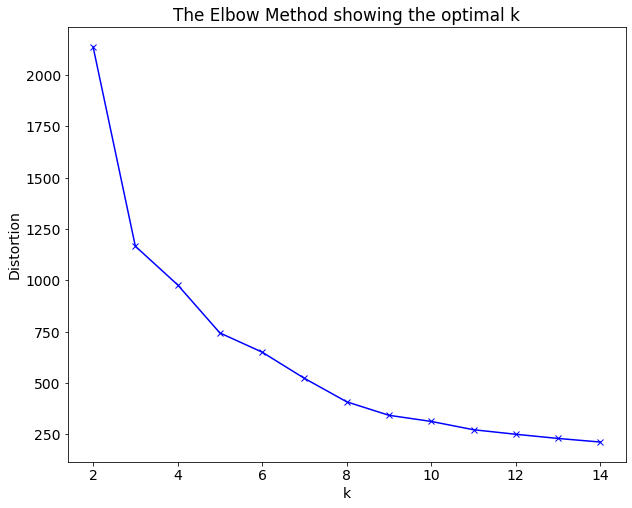

In [382]:
apply_elbow_method(components_3d)

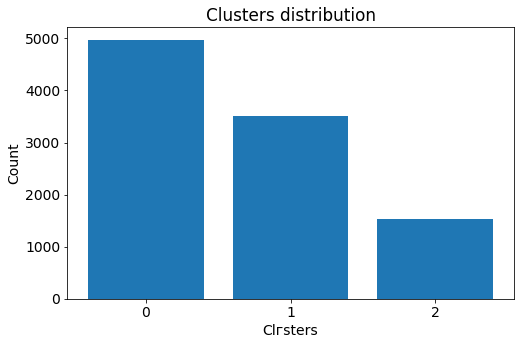

In [383]:
# видим что при 3 -кластерах пеерстает резко уменьшаться  межкластерное расстояние
kmeans_3 = KMeans(n_clusters=3, random_state=100)
labels_clast_3 = kmeans_3.fit_predict(components_3d)
labels_clast_3 = pd.Series(labels_clast_3, name='clusters_3')

unique, counts = np.unique(labels_clast_3, return_counts=True)
display_clusters_distribution(unique, counts)

In [384]:
# сохраним модельку 
with open(MODEL_TRAIN_KMEANS, 'wb') as file:
    pickle.dump(kmeans_3, file)

In [385]:
# установим индексы labels_clast_3 как у нашего датасета  df_features
labels_clast_3.index=df_features.index
labels_clast_3

Id
14038    0
15053    2
4765     0
5809     0
10783    0
        ..
77       0
6159     0
5123     1
5400     0
6306     0
Name: clusters_3, Length: 10000, dtype: int32

In [386]:
# добавим колонку  c нашими метками
df_features['components_3d']=labels_clast_3
df_features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,components_3d
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,...,5,0,11,0,1,0,1,0,1,0
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,...,1,1,16,0,1,0,1,0,1,2
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,...,0,1,3,0,1,0,1,0,1,0
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,...,3,0,5,0,1,0,1,0,1,0
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,...,1,2,4,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,46,...,6,3,11,0,1,0,1,0,1,0
6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,30,...,0,0,5,0,1,0,1,1,0,0
5123,27,1.0,47.939008,32.448004,1.0,12,16.0,2015,0.072158,2,...,1,0,0,0,1,0,1,1,0,1


In [387]:
df3=df_features.copy()

In [388]:
# сдедаем категорию из колокнки components_3d . чтобы запустить на нее dummies
df_features['components_3d']=df_features['components_3d'].astype("category")

In [389]:
df_features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,components_3d
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,...,5,0,11,0,1,0,1,0,1,0
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,...,1,1,16,0,1,0,1,0,1,2
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,...,0,1,3,0,1,0,1,0,1,0
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,...,3,0,5,0,1,0,1,0,1,0
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,...,1,2,4,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,46,...,6,3,11,0,1,0,1,0,1,0
6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,30,...,0,0,5,0,1,0,1,1,0,0
5123,27,1.0,47.939008,32.448004,1.0,12,16.0,2015,0.072158,2,...,1,0,0,0,1,0,1,1,0,1


In [390]:
# обработаем колонку components_3d в dummies как категорию
df_features=pd.get_dummies(df_features)
df_features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,components_3d_0,components_3d_1,components_3d_2
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,...,11,0,1,0,1,0,1,1,0,0
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,...,16,0,1,0,1,0,1,0,0,1
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,...,3,0,1,0,1,0,1,1,0,0
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,...,5,0,1,0,1,0,1,1,0,0
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,...,4,0,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,46,...,11,0,1,0,1,0,1,1,0,0
6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,30,...,5,0,1,0,1,1,0,1,0,0
5123,27,1.0,47.939008,32.448004,1.0,12,16.0,2015,0.072158,2,...,0,0,1,0,1,1,0,0,1,0


In [393]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DistrictId       10000 non-null  int64  
 1   Rooms            10000 non-null  float64
 2   Square           10000 non-null  float64
 3   LifeSquare       10000 non-null  float64
 4   KitchenSquare    10000 non-null  float64
 5   Floor            10000 non-null  int64  
 6   HouseFloor       10000 non-null  float64
 7   HouseYear        10000 non-null  int64  
 8   Ecology_1        10000 non-null  float64
 9   Social_1         10000 non-null  int64  
 10  Social_2         10000 non-null  int64  
 11  Social_3         10000 non-null  int64  
 12  Helthcare_2      10000 non-null  int64  
 13  Shops_1          10000 non-null  int64  
 14  Ecology_2_A      10000 non-null  uint8  
 15  Ecology_2_B      10000 non-null  uint8  
 16  Ecology_3_A      10000 non-null  uint8  
 17  Ecology_3

In [391]:
# вернем колонку price перед сохранением
df_features['Price']=df['Price']
df_features

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,components_3d_0,components_3d_1,components_3d_2,Price
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,...,0,1,0,1,0,1,1,0,0,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,...,0,1,0,1,0,1,0,0,1,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,...,0,1,0,1,0,1,1,0,0,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,...,0,1,0,1,0,1,1,0,0,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,...,0,1,0,1,0,1,1,0,0,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,46,...,0,1,0,1,0,1,1,0,0,196684.316040
6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,30,...,0,1,0,1,1,0,1,0,0,189050.289571
5123,27,1.0,47.939008,32.448004,1.0,12,16.0,2015,0.072158,2,...,0,1,0,1,1,0,0,1,0,159143.805370


In [392]:
## сохраняем препарированную базу С изменнеыми LifeSquare , KitchenSquare, и Yearhouse
df_features.to_csv(PREPARED_TRAIN_PATH, index=True, encoding='utf-8')